In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep = ";")
data = data[data['total sulfur dioxide'] < 200]

cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data['boolQuality'] = 0
for i in range(len(data)):
    if data.iloc[i, -2] > 5:
        data.iloc[i, -1] = 1

<ipython-input-3-70c70d3f4435>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
<ipython-input-3-70c70d3f4435>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'] = 0


In [ ]:
dataT = torch.tensor(data[cols2zscore].values).float()
labelsT =torch.tensor(data['boolQuality'].values).float()
labelsT = labelsT[:, None]
labelsT.shape

torch.Size([1597, 1])

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# train and test loaders
test_loader = DataLoader(train_dataset, batch_size = len(test_dataset), shuffle = True)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, drop_last = True)

In [ ]:
class ANNwine(nn.Module):
    def __init__(self):

        super().__init__()

        # input layer
        self.input = nn.Linear(11, 64)

        # hidden layers
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 20)

        # output layer
        self.output = nn.Linear(20, 1)

    def forward(self, X):
        X = F.relu(self.input(X))
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))

        return self.output(X)

In [ ]:
numepochs = 600

def trainTheModel(winenet):
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr = .01)

    # initialize losses
    losses = np.zeros(numepochs)
    trainAcc = []
    testAcc= []

    for epochi in range(numepochs):

        winenet.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:
            yHat = winenet(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

            batchAcc.append(100*torch.mean(((yHat > 0) == y).float()).item())

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        winenet.eval()
        X, y = next(iter(test_loader))
        with torch.inference_mode():
            yHat = winenet(X)
        testAcc.append(100*torch.mean(((yHat > 0) == y).float()).item())

    return trainAcc, testAcc, losses

In [ ]:

winenet_xavier = ANNwine()

# change the weights (leave biases as Kaiming)
for p in winenet_xavier.named_parameters():
    if 'weight' in p[0]:
        nn.init.xavier_normal_(p[1].data)

trainAcc_X, testAcc_X, losses_X = trainTheModel(winenet_xavier)



In [ ]:
winenet_kaiming = ANNwine()

for p in winenet_kaiming.named_parameters():
    if 'weight' in p[0]:
        nn.init.kaiming_uniform_(p[1].data, nonlinearity = 'relu')

trainAcc_K, testAcc_K, losses_K = trainTheModel(winenet_kaiming)


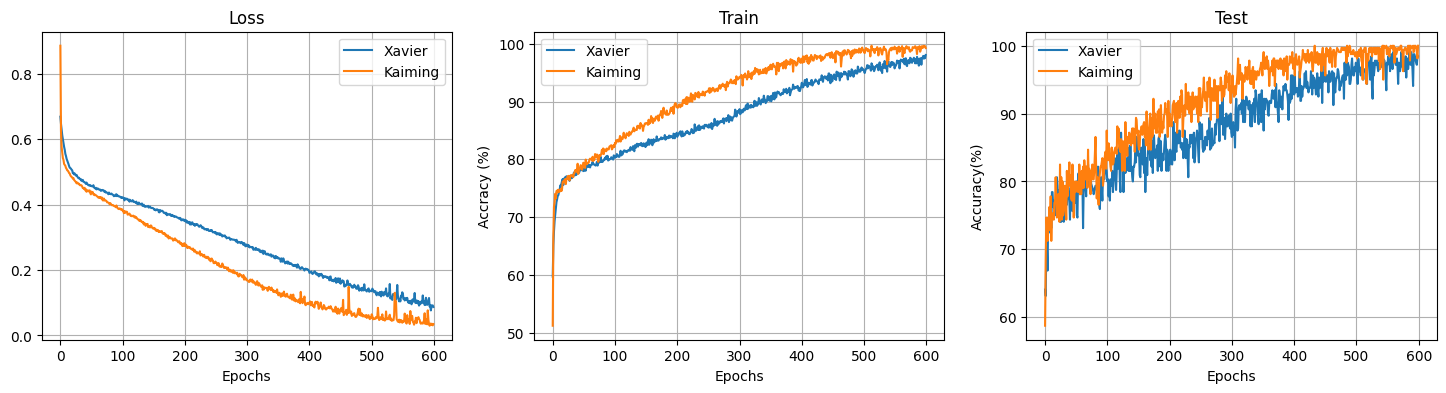

In [ ]:
# plot the results
fig, ax = plt.subplots(1, 3, figsize = (18, 4))

# losses
ax[0].plot(losses_X, label = 'Xavier')
ax[0].plot(losses_K, label = 'Kaiming')
ax[0].set_title('Loss')

# train accuracy
ax[1].plot(trainAcc_X, label = 'Xavier')
ax[1].plot(trainAcc_K, label = 'Kaiming')
ax[1].set_ylabel('Accracy (%)')
ax[1].set_title('Train')

# test accuracy
ax[2].plot(testAcc_X, label = 'Xavier')
ax[2].plot(testAcc_K, label = 'Kaiming')
ax[2].set_ylabel('Accuracy(%)')
ax[2].set_title('Test')


for i in range(3):
    ax[i].legend()
    ax[i].grid('on')
    ax[i].set_xlabel('Epochs')

plt.show()

In [ ]:
# number of experiment iterations
numExps = 10

results = np.zeros((numExps, 3, 2))

for expi in range(numExps):

    winenet_xavier = ANNwine()
    for p in winenet_xavier.named_parameters():
        if 'weight' in p[0]:
            nn.init.xavier_normal_(p[1].data)
    trainAcc_X, testAcc_X, losses_X = trainTheModel(winenet_xavier)

    winenet_kaiming = ANNwine()
    for p in winenet_kaiming.named_parameters():
        if 'weight' in p[0]:
            nn.init.kaiming_uniform_(p[1].data, nonlinearity = 'relu')

    trainAcc_K, testAcc_K, losses_K = trainTheModel(winenet_kaiming)

    results[i, 1, 0] = np.mean(trainAcc_X[-5:])
    results[i, 2, 0] = np.mean(testAcc_X[-5:])
    results[i, 0, 0] = np.mean(losses_X[-5:])

    results[i, 1, 1] = np.mean(trainAcc_K[-5:])
    results[i, 2, 1] = np.mean(testAcc_K[-5:])
    results[i, 0, 1] = np.mean(losses_K[-5:])

    print(f"Finished Run {expi}/{numExps}")

Finished Run 0/10
Finished Run 1/10
Finished Run 2/10
Finished Run 3/10
Finished Run 4/10
Finished Run 5/10
Finished Run 6/10
Finished Run 7/10
Finished Run 8/10
Finished Run 9/10


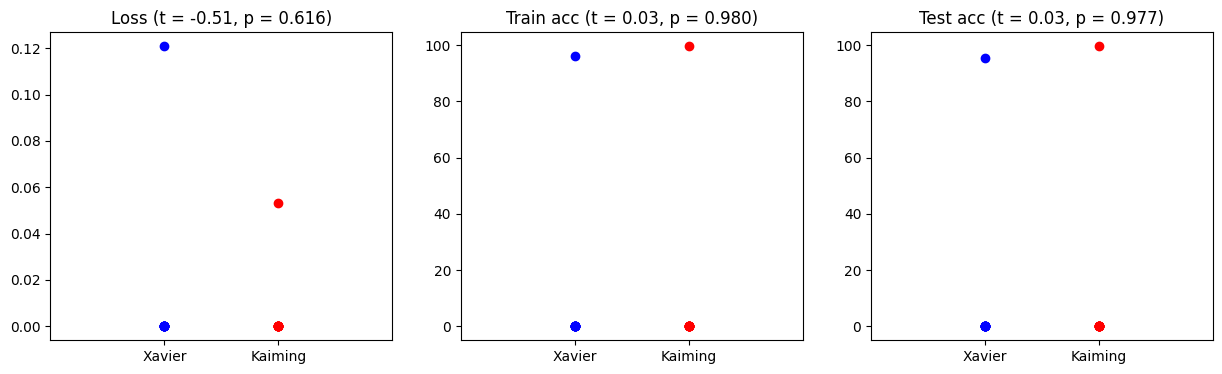

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))

# plot titles
metric = ['Loss', 'Train acc', 'Test acc']

for i in range(3):

    ax[i].plot(np.zeros(numExps), results[:,i, 0], 'bo')
    ax[i].plot(np.ones(numExps), results[:, i, 1], 'ro')

    # run a t-test to formalize the comparison
    t, p = stats.ttest_ind(results[:, i, 1], results[:, i, 0])
    title = '%s (t = %.2f, p = %.3f)' %(metric[i], t, p)

    # make the plot look a bit nicer
    ax[i].set_xlim([-1, 2])
    ax[i].set_xticks([0, 1])
    ax[i].set_xticklabels(['Xavier', "Kaiming"])
    ax[i].set_title(title)
plt.show()

In [ ]:
results

array([[[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       [[1.20852486e-01, 5.33646395e-02],
        [9.61217949e+01, 9.96153846e+01],
        [9.55625010e+01, 9.96249998e+01]],

       [[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e